In [ ]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas()

nltk.download('punkt')
nltk.download('stopwords')

#### The CBOW portuguese word embeddings can be downloaded:
http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [ ]:
file_path = 'olist_order_reviews_dataset.csv'
df = pd.read_csv(file_path)

df = df[['review_comment_title', 'review_comment_message', 'review_score']]

df.dropna(subset=['review_comment_title', 'review_comment_message'], how='all', inplace=True)
df.fillna(' ' , inplace=True)

In [ ]:
# combine the title and message columns into a single review column
df['reviews'] = df['review_comment_title'].str.cat(df['review_comment_message'], sep=" ")
# separate reviews into tokens
df['tokenized_reviews'] = df['reviews'].apply(lambda review: word_tokenize(review.lower()))

# replace emojis with words to match format expected by word embeddings
# df['processed_tokens'] = df['tokenized_reviews'].apply(replace_emojis)

# remove common words that don't have as much impact on the sentiment
df['processed_tokens'] = df['tokenized_reviews'].apply(remove_stopwords)

# combine the list of tokens back to a single string
df['joined_tokens'] = df['processed_tokens'].apply(' '.join)

In [ ]:
# load the pre-trained embedding model

# model_path = 'cbow_s100.txt'
# model_path = 'cbow_s300.txt'
model_path = 'cbow_s1000.txt'
w2v = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [ ]:
# turn each review into a single vector that conveys its
#    semantics via the tokens found in the word2vec embeddings
def document_vector(doc, w2v):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v.key_to_index]
    if not doc:
        return np.zeros(1000)
    return np.mean(w2v[doc], axis=0)


100%|██████████| 42706/42706 [00:00<00:00, 53730.87it/s]


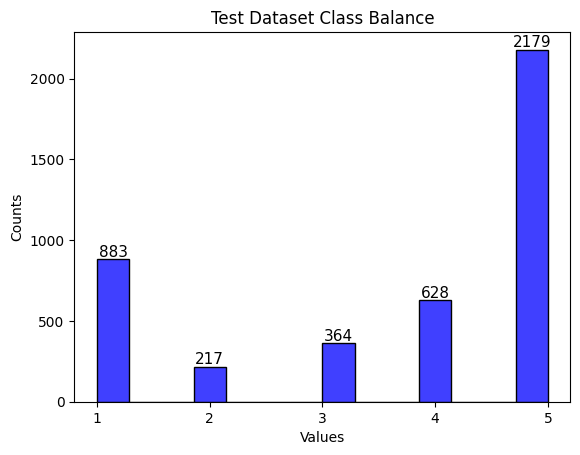

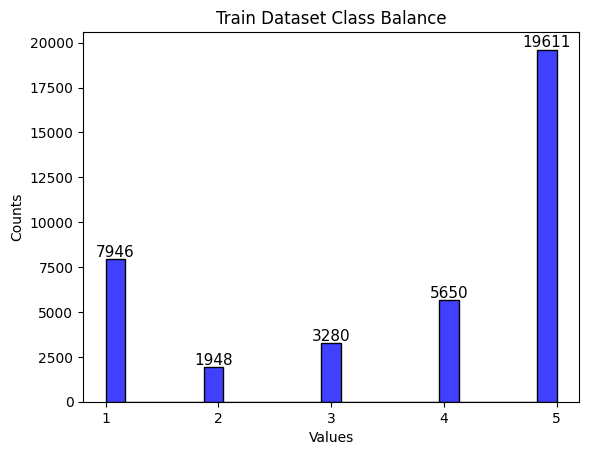

In [ ]:
# apply the function to convert review texts to vectors
df['doc_vector'] = df['joined_tokens'].progress_apply(lambda x: document_vector(x.split(), w2v))

X = np.array(list(df['doc_vector']))
y = df['review_score'].values

# convert to 0 indexed
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

plot_class_distribution(y_test, 'Test Dataset Class Balance')
plot_class_distribution(y_train, 'Train Dataset Class Balance')

In [ ]:
param_grid = {'max_depth': [3, 6, 10],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]}
            #   'n_estimators': [100,  500, 1000],
            #   'subsample': [0.5, 0.7, 1.0]}

data = (X_train, y_train, X_test, y_test)

# using my common functions at top of notebook
xgboost_pipe, grid_search_results = \
    perform_grid_search(data=data,
                        grid_params=param_grid,
                        classifier_func=XGBClassifier,
                        cv=5, random_state=42
                       )

print_grid_search_results(xgboost_pipe, data,
                          print_model_select=True,
                          print_best_params=True,
                          print_all_scores=False)

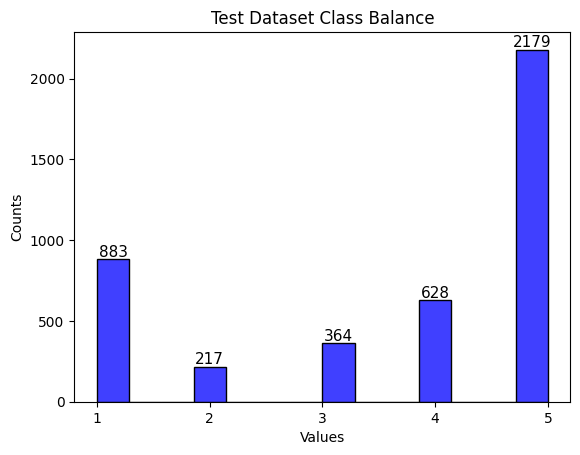

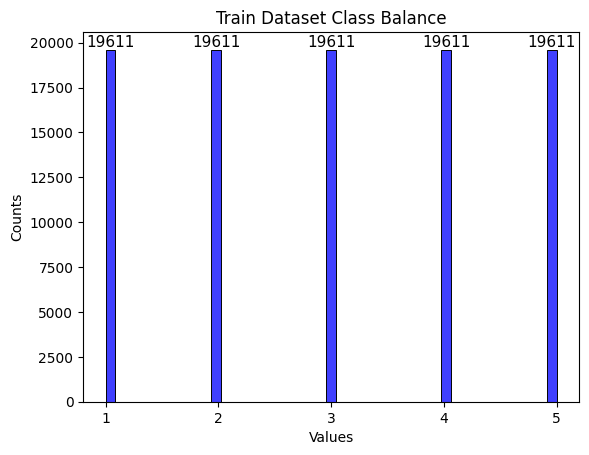

In [ ]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

plot_class_distribution(y_test, 'Test Dataset Class Balance')
plot_class_distribution(y_train, 'Train Dataset Class Balance')

[0]	validation_0-mlogloss:1.56530	validation_0-merror:0.35767	validation_0-auc:0.81629	validation_1-mlogloss:1.56812	validation_1-merror:0.38258	validation_1-auc:0.78229
[1]	validation_0-mlogloss:1.52509	validation_0-merror:0.35181	validation_0-auc:0.82975	validation_1-mlogloss:1.53112	validation_1-merror:0.37602	validation_1-auc:0.78908
[2]	validation_0-mlogloss:1.48838	validation_0-merror:0.35106	validation_0-auc:0.83389	validation_1-mlogloss:1.49711	validation_1-merror:0.37392	validation_1-auc:0.79327
[3]	validation_0-mlogloss:1.45449	validation_0-merror:0.34887	validation_0-auc:0.83784	validation_1-mlogloss:1.46587	validation_1-merror:0.37134	validation_1-auc:0.79730
[4]	validation_0-mlogloss:1.42312	validation_0-merror:0.34653	validation_0-auc:0.84130	validation_1-mlogloss:1.43737	validation_1-merror:0.37158	validation_1-auc:0.79973
[5]	validation_0-mlogloss:1.39389	validation_0-merror:0.34458	validation_0-auc:0.84610	validation_1-mlogloss:1.41086	validation_1-merror:0.37064	valid

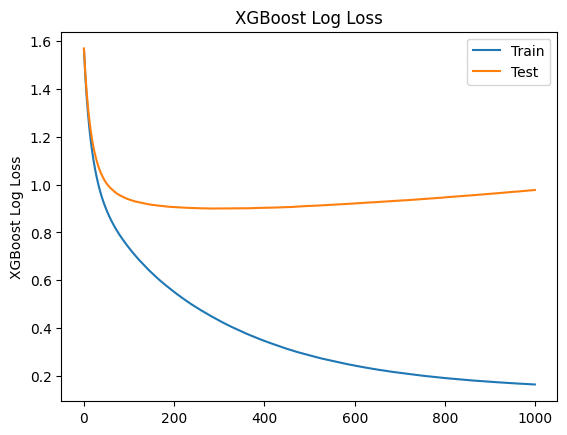

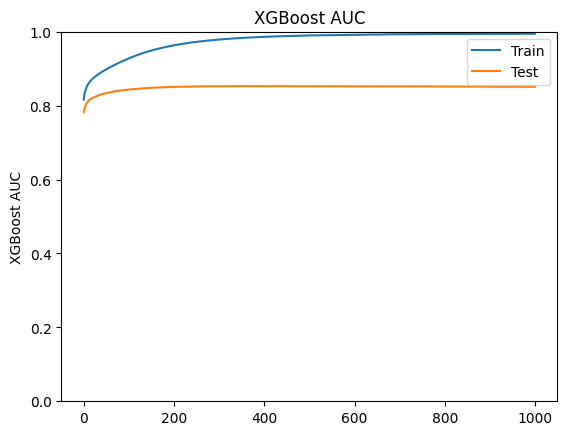

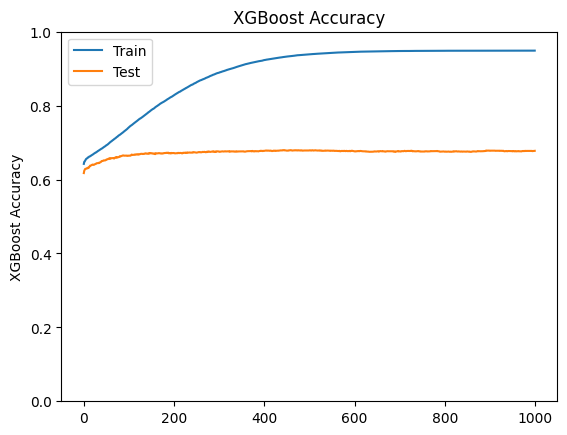

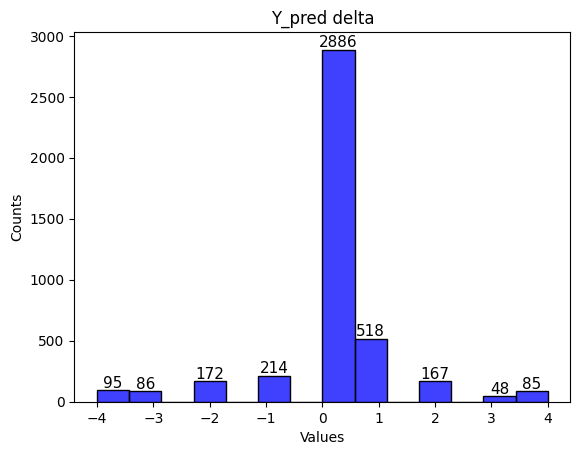

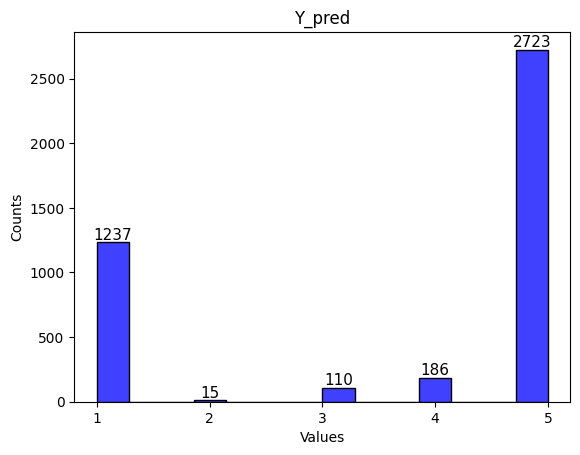

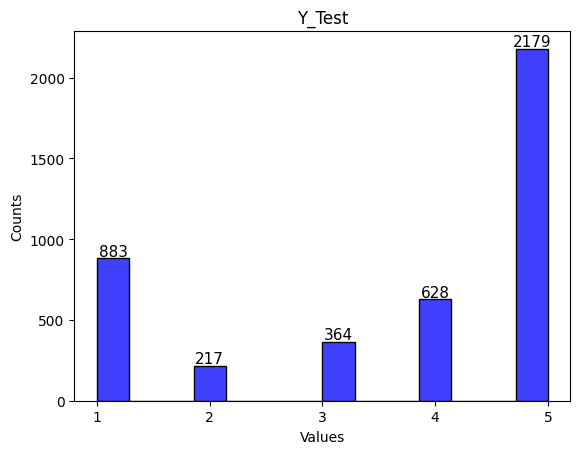

In [ ]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    learning_rate=0.05,
    max_depth=6, # 10 best
    # subsample=0.5,
    eval_metric=['mlogloss', 'merror', 'auc'],
    num_class=len(np.unique(y)),
    objective='multi:softmax',
    early_stopping_rounds=1000,
    n_jobs=0,
    n_estimators=1000
)


model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

evals_result = model.evals_result()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("AUC on test set:", evals_result['validation_1']['auc'][-1])

plot_metrics(evals_result, 'XGBoost Log Loss', metric='mlogloss')
plot_metrics(evals_result, 'XGBoost AUC', metric='auc')
plot_metrics(evals_result, 'XGBoost Accuracy', metric='merror')


plot_class_distribution(y_pred-y_test, 'Y_pred delta', add_one=False, bin_range=None)
plot_class_distribution(y_pred, 'Y_pred')
plot_class_distribution(y_test, 'Y_Test')

Word2Vec 100, max depth 10, learning rate 0.01, no over sampling

Accuracy on test set: 0.6480917817841255
AUC on test set: 0.8269557855527684


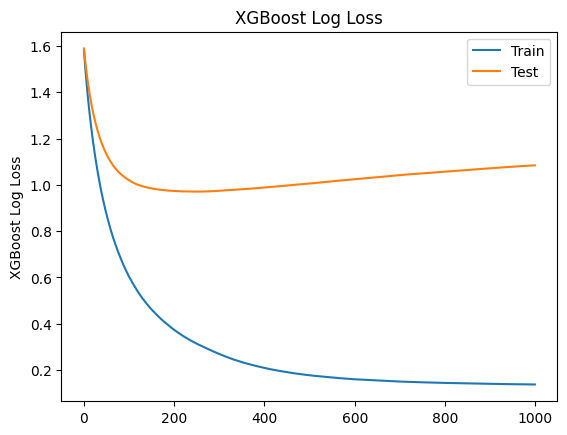

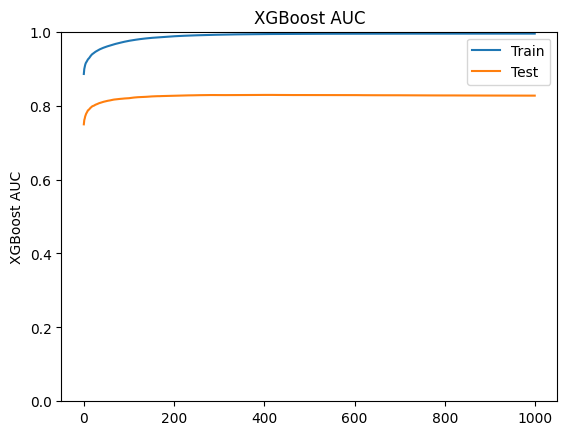

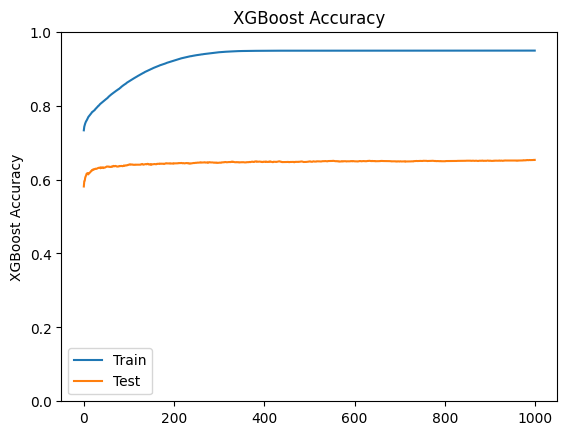

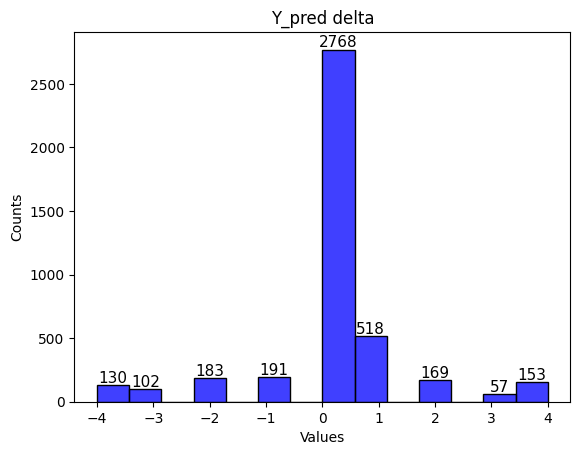

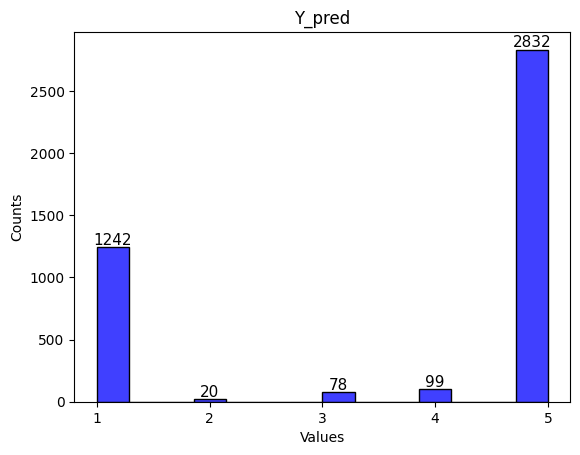

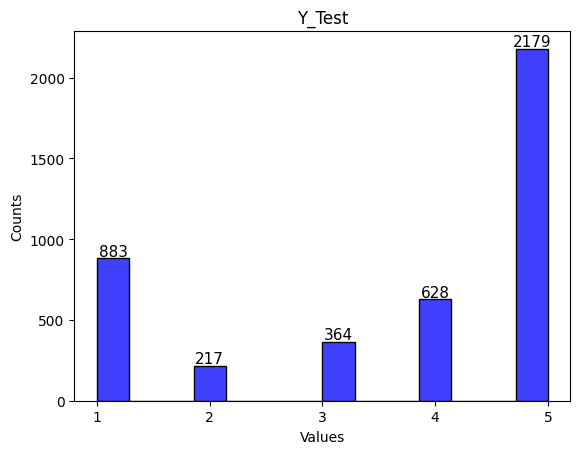

In [ ]:
print('Word2Vec 100, max depth 10, learning rate 0.01, no over sampling\n')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)
print('AUC on test set:', evals_result['validation_1']['auc'][-1])

plot_metrics(evals_result, 'XGBoost Log Loss', metric='mlogloss')
plot_metrics(evals_result, 'XGBoost AUC', metric='auc')
plot_metrics(evals_result, 'XGBoost Accuracy', metric='merror')


plot_class_distribution(y_pred-y_test, 'Y_pred delta', add_one=False, bin_range=None)
plot_class_distribution(y_pred, 'Y_pred')
plot_class_distribution(y_test, 'Y_Test')

Word2Vec 1000, max depth 10, learning rate 0.025, no over sampling

Accuracy on test set: 0.6621400140482323
AUC on test set: 0.8416497082461807


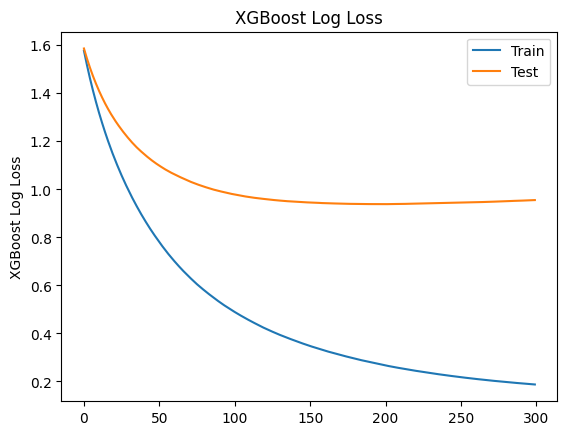

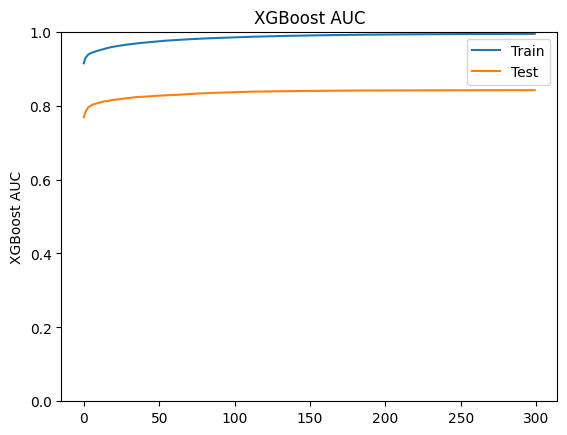

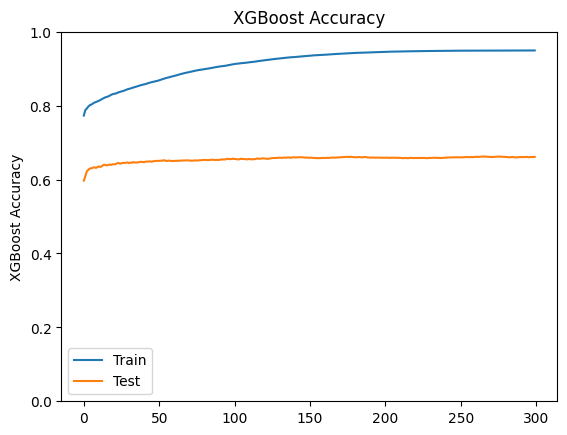

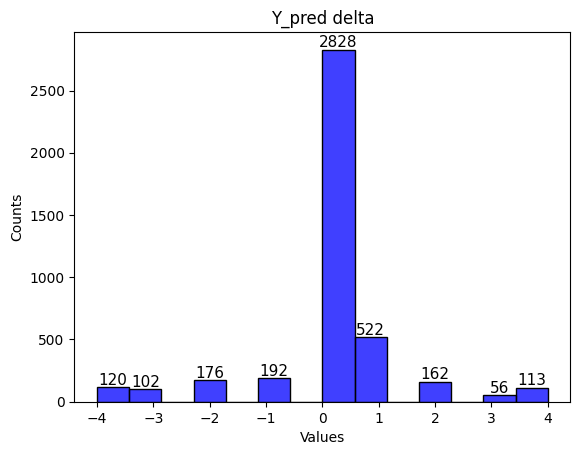

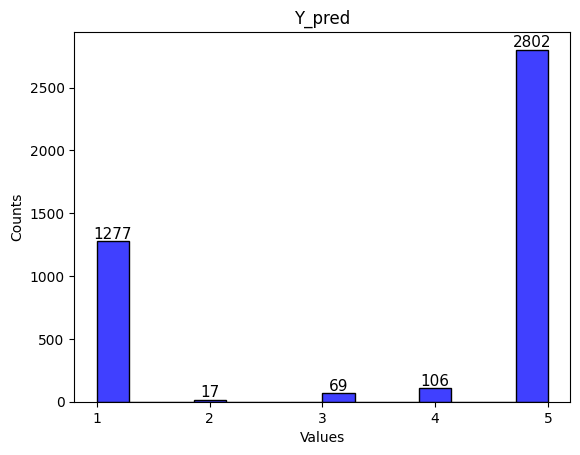

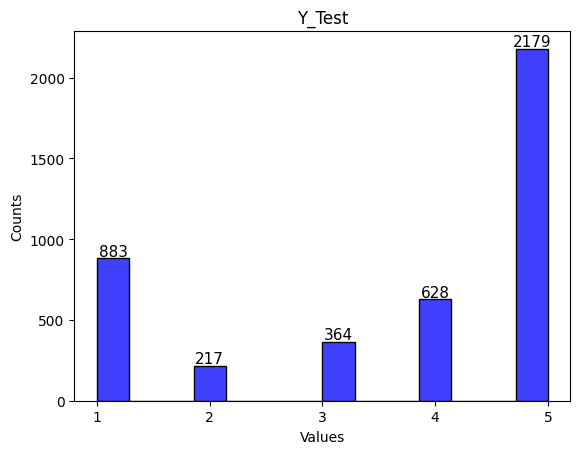

In [ ]:
print('Word2Vec 1000, max depth 10, learning rate 0.025, no over sampling\n')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)
print('AUC on test set:', evals_result['validation_1']['auc'][-1])

plot_metrics(evals_result, 'XGBoost Log Loss', metric='mlogloss')
plot_metrics(evals_result, 'XGBoost AUC', metric='auc')
plot_metrics(evals_result, 'XGBoost Accuracy', metric='merror')


plot_class_distribution(y_pred-y_test, 'Y_pred delta', add_one=False, bin_range=None)
plot_class_distribution(y_pred, 'Y_pred')
plot_class_distribution(y_test, 'Y_Test')

Word2Vec 1000, max depth 6, learning rate 0.05, no over sampling

Accuracy on test set: 0.6757199719035355
AUC on test set: 0.8523652700296593


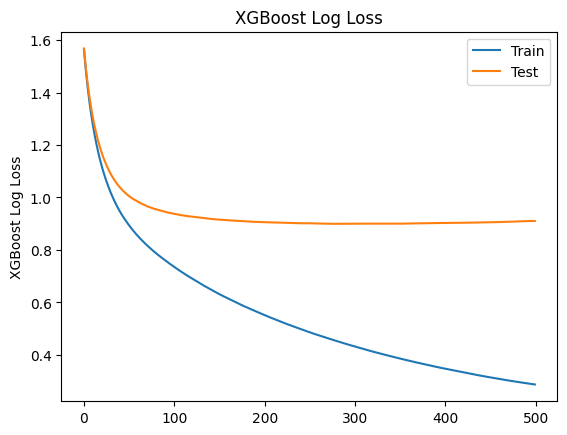

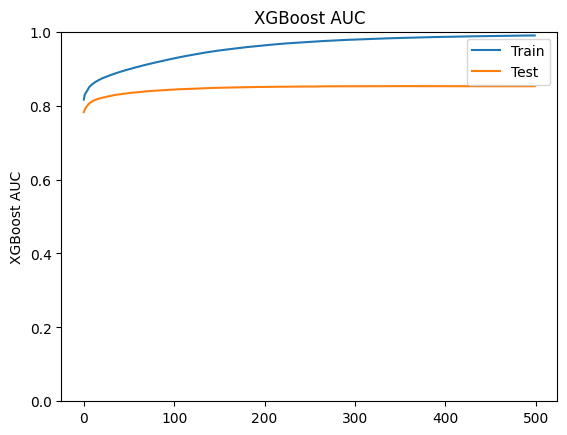

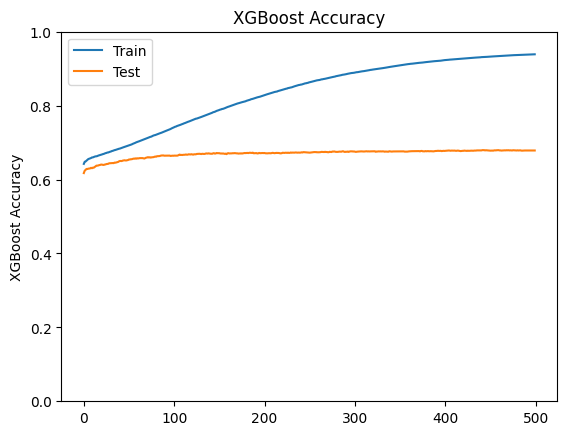

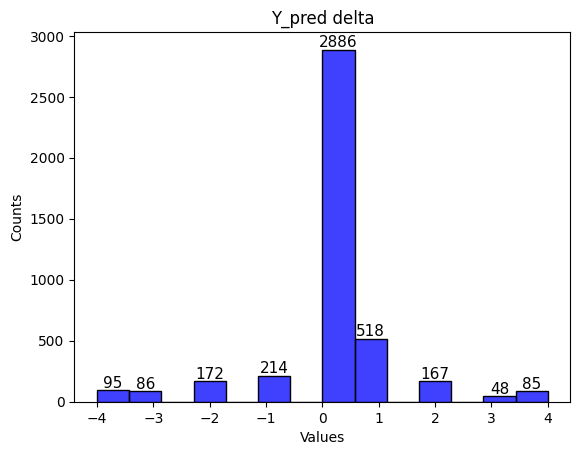

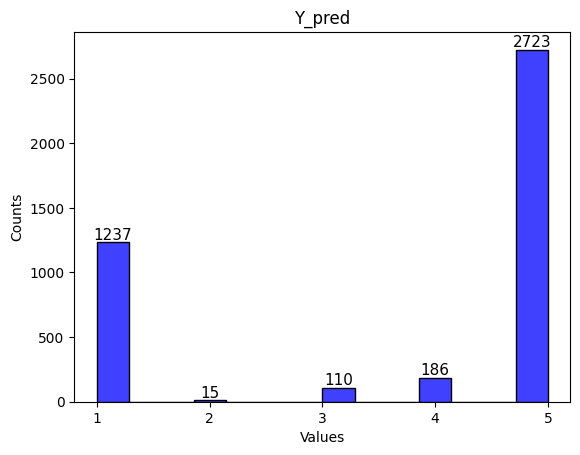

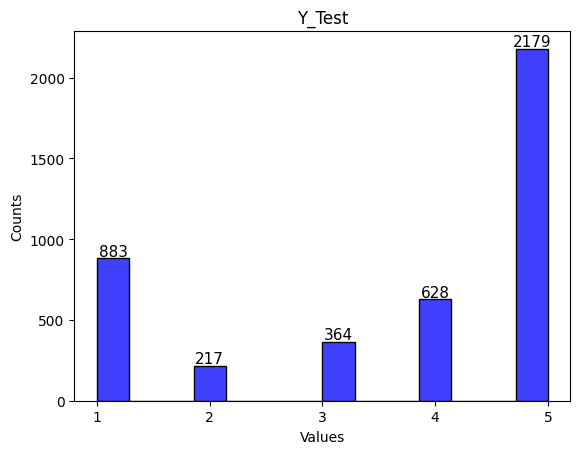

In [ ]:
print('Word2Vec 1000, max depth 6, learning rate 0.05, no over sampling\n')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)
print('AUC on test set:', evals_result['validation_1']['auc'][-1])

plot_metrics(evals_result, 'XGBoost Log Loss', metric='mlogloss')
plot_metrics(evals_result, 'XGBoost AUC', metric='auc')
plot_metrics(evals_result, 'XGBoost Accuracy', metric='merror')


plot_class_distribution(y_pred-y_test, 'Y_pred delta', add_one=False, bin_range=None)
plot_class_distribution(y_pred, 'Y_pred')
plot_class_distribution(y_test, 'Y_Test')

Word2Vec 1000, max depth 6, learning rate 0.01, no over sampling

Accuracy on test set: 0.6658862093186607
AUC on test set: 0.8436462597554545


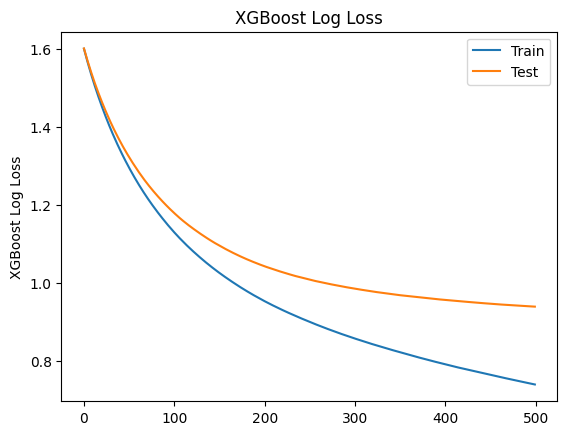

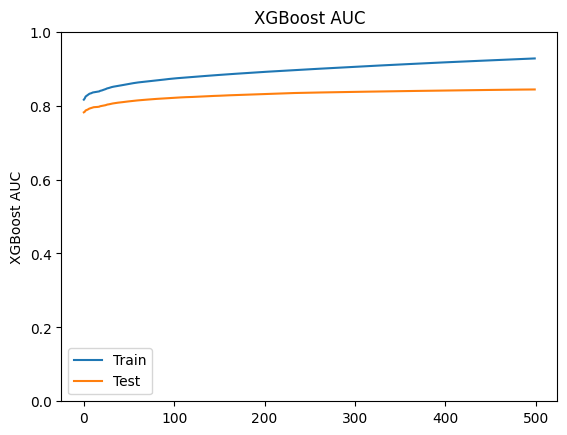

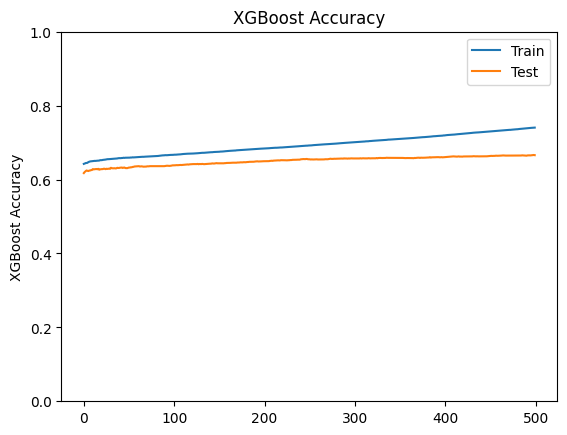

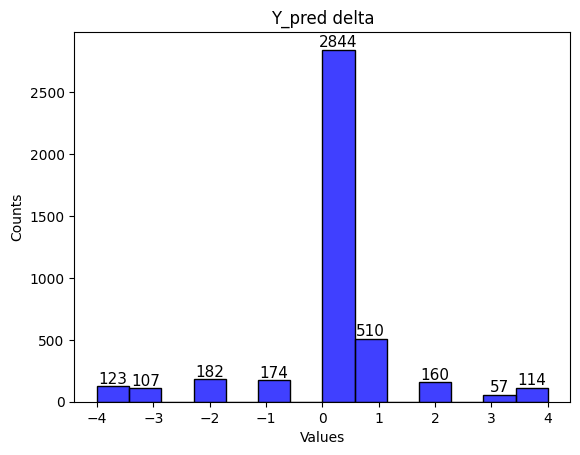

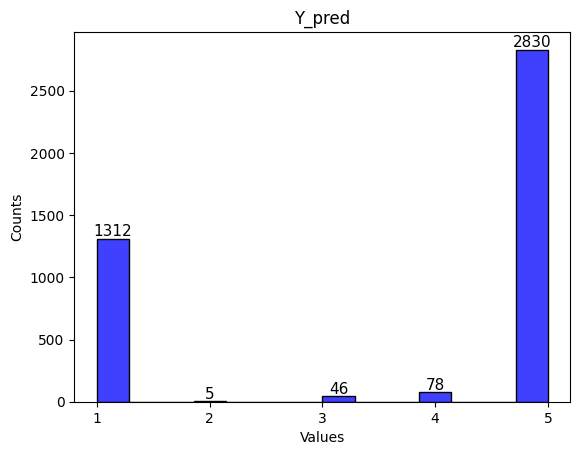

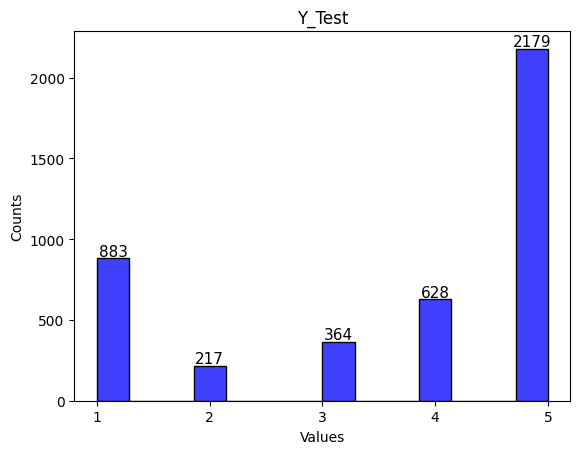

In [ ]:
print('Word2Vec 1000, max depth 6, learning rate 0.01, no over sampling\n')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)
print('AUC on test set:', evals_result['validation_1']['auc'][-1])

plot_metrics(evals_result, 'XGBoost Log Loss', metric='mlogloss')
plot_metrics(evals_result, 'XGBoost AUC', metric='auc')
plot_metrics(evals_result, 'XGBoost Accuracy', metric='merror')


plot_class_distribution(y_pred-y_test, 'Y_pred delta', add_one=False, bin_range=None)
plot_class_distribution(y_pred, 'Y_pred')
plot_class_distribution(y_test, 'Y_Test')

In [ ]:
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', verbose=True)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_prob = clf.predict_proba(X_test)

auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
print("AUC Score:", auc)

loss = log_loss(y_test, y_prob)
print("Log Loss:", loss)


In [ ]:
def plot_class_distribution(data, title, add_one=True, bin_range=(1, 6)):
    if add_one:
        data = [val + 1 for val in data]
    ax = sns.histplot(data, kde=False, color='blue')
    if bin_range is not None:
        first_bin, last_bin = bin_range
        plt.xticks(np.arange(first_bin, last_bin, 1))

    # Annotate each bar with the count of data points in the bin
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                        textcoords='offset points')

    # Plot configuration
    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.show()

# Plotting training and validation metrics
def plot_metrics(evals_result, title, metric='auc'):
    epochs = len(evals_result['validation_0'][metric])
    x_axis = range(0, epochs)

    # Plot log loss
    fig, ax = plt.subplots()
    if 'error' in metric:
        ax.plot(x_axis, [1.0 - val for val in evals_result['validation_0']['merror']], label='Train')
        # ax.plot(x_axis, [1.0 - val for val in evals_result['validation_2']['merror']], label='Test')
        if 'validation_2' in evals_result:
            ax.plot(x_axis, [1.0 - val for val in evals_result['validation_1']['merror']], label='Validation')
            ax.plot(x_axis, [1.0 - val for val in evals_result['validation_2']['merror']], label='Test')
        else:
            ax.plot(x_axis, [1.0 - val for val in evals_result['validation_1']['merror']], label='Test')
    else:
        ax.plot(x_axis, evals_result['validation_0'][metric], label='Train')
        if 'validation_2' in evals_result:
            ax.plot(x_axis, evals_result['validation_1'][metric], label='Validation')
            ax.plot(x_axis, evals_result['validation_2'][metric], label='Test')
        else:
            ax.plot(x_axis, evals_result['validation_1'][metric], label='Test')
    ax.legend()
    if 'log' not in metric:
        plt.ylim((0, 1.0))
    plt.ylabel(title)
    plt.title(f'{title}')
    plt.show()


def perform_grid_search(data,
                        # preprocess,
                        grid_params,
                        scoring=None, # 'plot_all'
                        classifier_func=DecisionTreeClassifier(),
                        cv=5,
                        random_state=42):

    dev_X, dev_y, _, _ = data

    # pipe = make_pipeline(preprocess,
    pipe = make_pipeline(GridSearchCV(
                            classifier_func(random_state=random_state),
                            param_grid=grid_params,
                            scoring=None if not isinstance(scoring, dict) else scoring,
                            refit= not isinstance(scoring, dict),
                            n_jobs=-1, # -1 to use all processors
                            cv=[(slice(None), slice(None))] if cv is None else cv,
                            verbose=2,
                            return_train_score=True,
                            )
                        )

    # pipe.fit(dev_X, dev_y.Outcome.values.reshape(-1,))
    pipe.fit(dev_X, dev_y)
    grid_search_results = pipe.named_steps['gridsearchcv']

    return pipe, grid_search_results

def print_grid_search_results(pipe,
                              data,
                              print_model_select=False,
                              print_best_params=False,
                              print_all_scores=False):

    dev_X, dev_y, test_X, test_y = data

    # This will allow using this print func for non grid searches
    #    where pipe won't have a gridsearchcv step
    try:
        grid_search_results = pipe.named_steps['gridsearchcv']
    except:
        pass

    if print_model_select:
        cv = grid_search_results.cv

        # selection_duration = grid_search_results.cv_results_['mean_fit_time']
        selection_duration = grid_search_results.cv_results_

        # multiply by the number of kfolds in cross validation
        cv_kfolds = cv if isinstance(cv, int) else 1

        # divide by the number of jobs used
        import multiprocessing
        max_jobs = multiprocessing.cpu_count()
        n_jobs = grid_search_results.n_jobs
        n_jobs = max_jobs if n_jobs == -1 else n_jobs
        n_jobs = n_jobs if n_jobs > 0 else 1
        selection_duration = \
            grid_search_results.cv_results_['mean_fit_time'].sum() * cv_kfolds / n_jobs
        print(f'Model selection time: {selection_duration:.3f} secs')
        print(f'(cv={cv if cv_kfolds > 1 else None})\n')

    if print_best_params:
        print(f'Test score: {pipe.score(test_X, test_y):.5f}')
        print(f'Best score: {grid_search_results.best_score_:.5f}')
        print(f'Best params: {grid_search_results.best_params_}\n')

    if print_all_scores:
        dev_y_pred = pipe.predict(dev_X)
        test_y_pred = pipe.predict(test_X)
        print(f'Train  Accuracy: {accuracy_score(dev_y, dev_y_pred):.4f}')
        print(f'Test   Accuracy: {accuracy_score(test_y, test_y_pred):.4f}\n')
        print(f'Train Precision: {precision_score(dev_y, dev_y_pred):.4f}')
        print(f'Test  Precision: {precision_score(test_y, test_y_pred):.4f}\n')
        print(f'Train    recall: {recall_score(dev_y, dev_y_pred):.4f}')
        print(f'Test     recall: {recall_score(test_y, test_y_pred):.4f}\n')
        print(f'Train        F1: {f1_score(dev_y, dev_y_pred):.4f}')
        print(f'Test         F1: {f1_score(test_y, test_y_pred):.4f}')

def plot_grid_search(scoring, grid_params, param_title, results, y_lim, x_lim=None):
    param_name = list(grid_params.keys())[0] # There is only 1 parameter
    param_range = grid_params[param_name]

    plt.figure(figsize=(15, 5))

    plt.title(f'GridSearchCV Evaluating {param_title}', fontsize=16)

    plt.xlabel(param_title)
    plt.ylabel('Score')

    ax = plt.gca()
    ax.set_ylim(y_lim)
    if x_lim is not None:
        ax.set_xlim(x_lim)

    X_axis = np.array(results[f'param_{param_name}'].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["r", "g", "b", "m"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

    max_acc = results['mean_test_Accuracy'].max()
    max_idx = np.argmax(results['mean_test_Accuracy'])
    max_ccp_a = param_range[max_idx]
    print(f'Best {param_name}: {max_ccp_a}, Accuracy: {max_acc}')
    if 'Precision' in scoring:
        max_pr = results['mean_test_Precision'].max()
        max_idx = np.argmax(results['mean_test_Precision'])
        max_ccp_a = param_range[max_idx]
        print(f'Best {param_name}: {max_ccp_a}, Precision: {max_pr}')
    max_rec = results['mean_test_Recall'].max()
    max_idx = np.argmax(results['mean_test_Recall'])
    max_ccp_a = param_range[max_idx]
    print(f'Best {param_name}: {max_ccp_a}, Recall: {max_rec}')
    max_f1 = results['mean_test_F1'].max()
    max_idx = np.argmax(results['mean_test_F1'])
    max_ccp_a = param_range[max_idx]
    print(f'Best {param_name}: {max_ccp_a}, F1: {max_f1}')

In [ ]:
def replace_emojis(text, debug=False):
    joined_text = ' '.join(text)
    if debug:
        print(joined_text)
    disappointed = 'decepcionada'
    disappointed_list = ['👎']
    for c in disappointed_list:
        joined_text = joined_text.replace(c, f'{disappointed} ')

    perfect = 'perfeito'
    perfect_list = ['😍', '😘', '😎', '😊', '😉', '😏', '😃', '😀', '🤗', '👍']
    for c in perfect_list:
        joined_text = joined_text.replace(c, f'{perfect} ')

    elated = 'exaltada'
    elated_list = ['💖', '💚', '💋', '🌟', '👐']
    for c in elated_list:
        joined_text = joined_text.replace(c, f'{elated} ')

    joined_text = joined_text.replace('👏' , 'aplaudir ') # clap
    joined_text = joined_text.replace('🤙', 'relaxado ')
    joined_text = joined_text.replace('😂', 'hilária ')
    joined_text = joined_text.replace('😠', 'nervosa ')
    joined_text = joined_text.replace('😠', 'nervosa ')
    joined_text = joined_text.replace('😣', 'frustrante ')
    joined_text = joined_text.replace('😕', 'triste ')
    joined_text = joined_text.replace('😐', 'medíocre ')
    joined_text = joined_text.replace('👊', 'soco ') # punch
    joined_text = joined_text.replace('🙏', 'obrigado ') # thanks

    joined_text = joined_text.replace('🐕', 'cadela ')
    joined_text = joined_text.replace('🚚', 'entrega ')
    joined_text = joined_text.replace('🔟', 'melhor ') # best
    joined_text = joined_text.replace('💥', 'excitada ')
    joined_text = joined_text.replace('$' , 'custo ') # cost
    joined_text = joined_text.replace('d\'', 'APOS')
    joined_text = joined_text.replace('\'', '') # remove apostrophes except d'
    joined_text = joined_text.replace('APOS', 'd\'')

    for c in ['🏻', '!', '´', '?', 'ª', 'º', '[', ']', '|', '*', '&', '@', '(', ')']:
        joined_text = joined_text.replace(c, '')

    for c in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']:
        joined_text = joined_text.replace(c, '')

    for c in ['~', '=', '_', ',', '.', '+', '÷', ',' '-', '/', '^', '#', '°', ':', ';', '\\']:
        joined_text = joined_text.replace(c, '')

    joined_text = joined_text.replace('  ', ' ')
    if debug:
        print(joined_text)
    return joined_text.split(' ')

stop_words = set(stopwords.words('portuguese'))
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]